In [2]:
library(dplyr)
library(tidyverse)
library(lubridate)
library(caret)
library(zoo)
library(xgboost)
library(gbm)
library(glmnet)
library(Metrics)
library(forecast)
library(tseries)
library(ggplot2)

In [3]:
# Load datasets
features <- read.csv("features.csv")
stores <- read.csv("stores.csv")
train <- read.csv("train.csv")
test <- read.csv("test.csv")

In [4]:
# Convert Date columns to Date type
features$Date <- as.Date(features$Date, format="%Y-%m-%d")
test$Date <- as.Date(test$Date, format="%Y-%m-%d")
train$Date <- as.Date(train$Date, format="%Y-%m-%d")

### Analyze Weekly Sales Trend

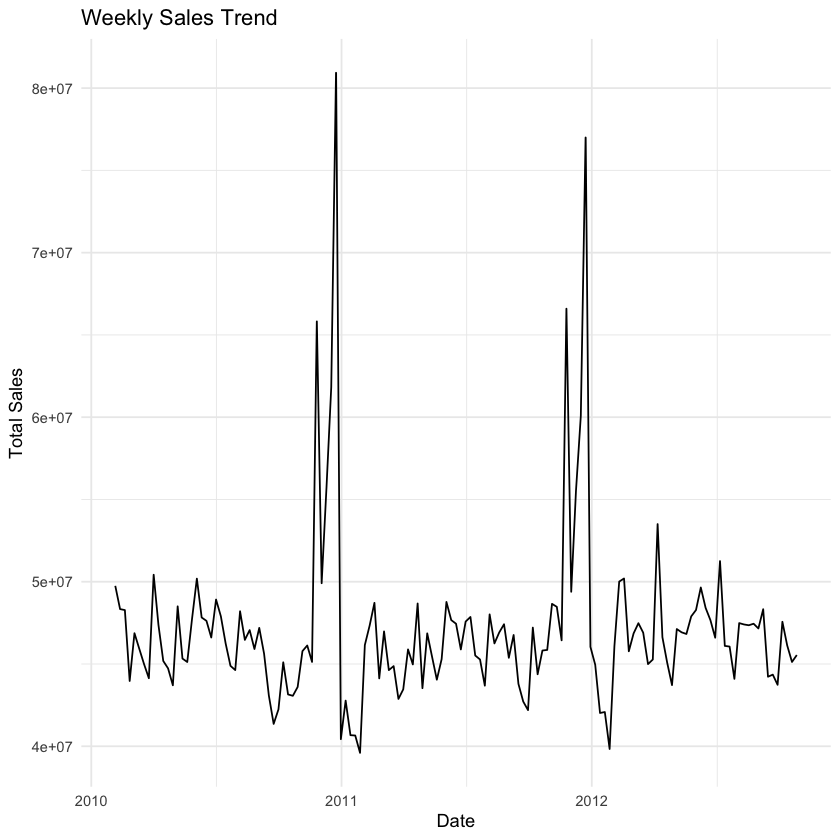

In [5]:
# Aggregate weekly sales for trend analysis
sales_trend <- train |>
  group_by(Date) |>
  summarize(Total_sales = sum(Weekly_Sales))

# PLot the sales trend
sales_trend |>
  ggplot(aes(x = Date, y = Total_sales)) +
  geom_line() +
  labs(
    title = "Weekly Sales Trend",
    x = "Date",
    y = "Total Sales"
  ) +
  theme_minimal()

### Analyze Seasonality

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


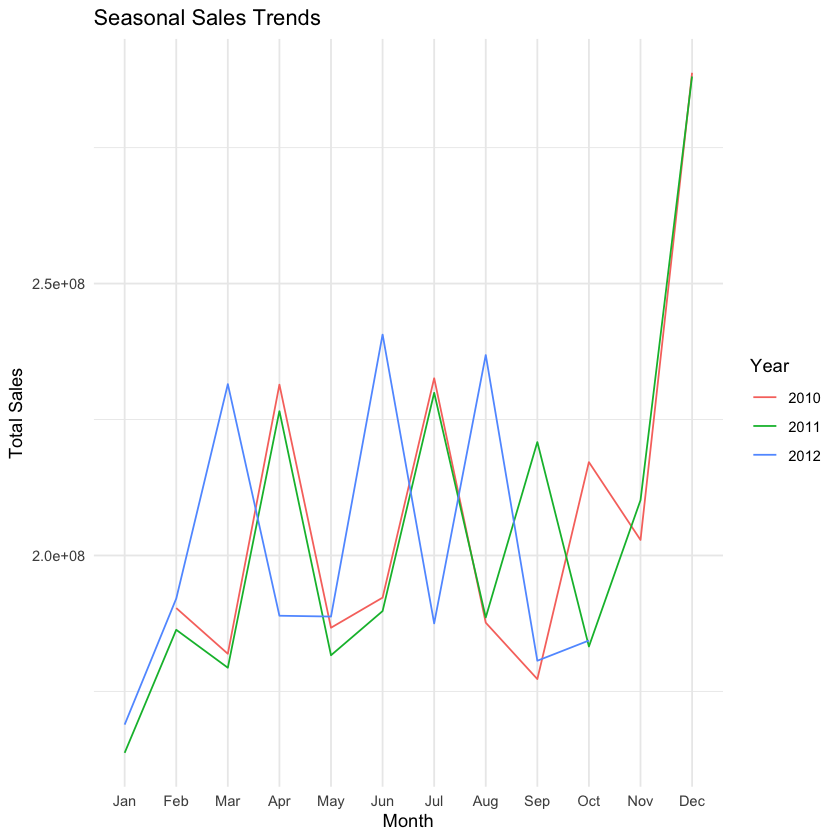

In [6]:
# Extract year and month
train <- train |>
    mutate(Year = year(Date), Month = month(Date, label = TRUE))

# Aggregate sales by month
monthly_sales <- train |>
    group_by(Year, Month) |>
    summarize(Total_Sales = sum(Weekly_Sales))

# Plot seasonal trends
monthly_sales |>
    ggplot(aes(x = Month, y = Total_Sales, group = Year, color = as.factor(Year))) +
    geom_line() +
    labs(
        title = "Seasonal Sales Trends",
        x = "Month",
        y = "Total Sales",
        color = "Year"
    ) +
    theme_minimal()

### Handle Missing Values in Features Dataset

In [7]:
# Check for missing values
missing_values <- colSums(is.na(features))
print(missing_values)

       Store         Date  Temperature   Fuel_Price    MarkDown1    MarkDown2 
           0            0            0            0         4158         5269 
   MarkDown3    MarkDown4    MarkDown5          CPI Unemployment    IsHoliday 
        4577         4726         4140          585          585            0 


In [8]:
# Replace missing values with median or a placeholder
features <- features %>%
  mutate(across(starts_with("MarkDown"), ~ ifelse(is.na(.), median(., na.rm = TRUE), .)),
         CPI = ifelse(is.na(CPI), median(CPI, na.rm = TRUE), CPI),
         Unemployment = ifelse(is.na(Unemployment), median(Unemployment, na.rm = TRUE), Unemployment))

### Identify Sales Distributions Across Stores

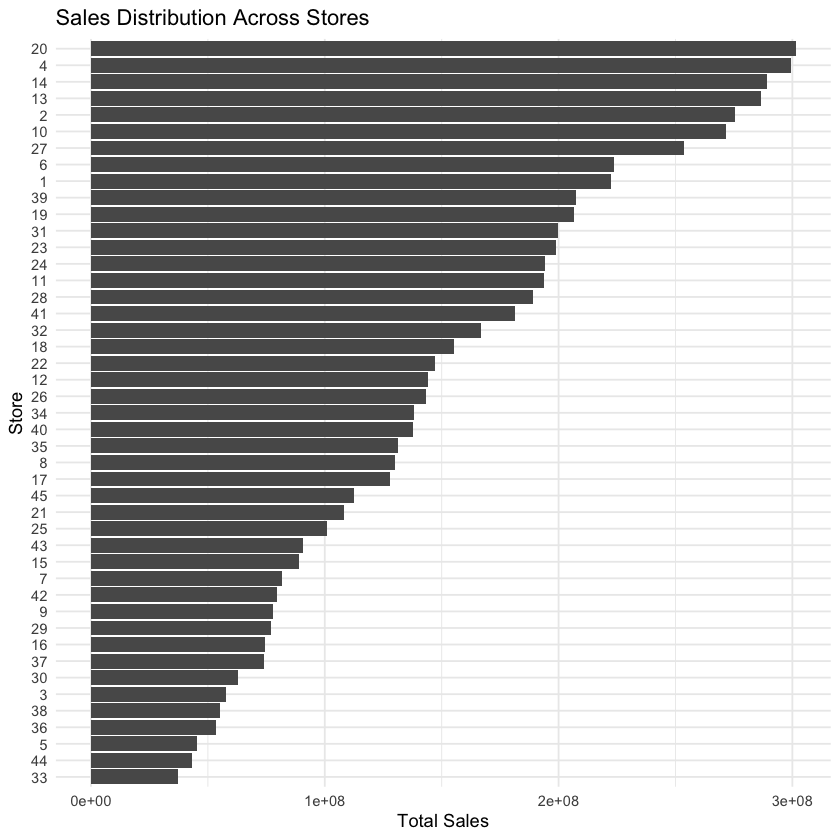

In [9]:
# Aggregate sales by store
store_sales <- train |>
    group_by(Store) |>
    summarize(Total_Sales = sum(Weekly_Sales))

# Plot sales distribution
store_sales |>
    ggplot(aes(x = reorder(as.factor(Store), Total_Sales), y = Total_Sales)) +
    geom_bar(stat = "identity") +
    labs(
        title = "Sales Distribution Across Stores",
        x = "Store",
        y = "Total Sales"
    ) +
    theme_minimal() +
    coord_flip()

### Merge Datasets for Analysis

In [10]:
train_combined <- train |>
    left_join(features, by = c("Store", "Date")) |>
    left_join(stores, by = "Store")

train_combined <- train_combined[, !names(train_combined) %in% "IsHoliday.x"]
names(train_combined)[names(train_combined) == "IsHoliday.y"] <- "IsHoliday"

test_combined <- test |>
    left_join(features, by = c("Store", "Date")) |>
    left_join(stores, by = "Store")

test_combined <- test_combined[, !names(test_combined) %in% "IsHoliday.x"]
names(test_combined)[names(test_combined) == "IsHoliday.y"] <- "IsHoliday"

head(train_combined)
head(test_combined)

,Store,Dept,Date,Weekly_Sales,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
,<int>,<int>,<date>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>
1,1,1,2010-02-05,24924.50,2010,Feb,42.31,2.572,4743.58,364.57,36.26,1176.425,2727.135,211.0964,8.106,FALSE,A,151315
2,1,1,2010-02-12,46039.49,2010,Feb,38.51,2.548,4743.58,364.57,36.26,1176.425,2727.135,211.2422,8.106,TRUE,A,151315
3,1,1,2010-02-19,41595.55,2010,Feb,39.93,2.514,4743.58,364.57,36.26,1176.425,2727.135,211.2891,8.106,FALSE,A,151315
4,1,1,2010-02-26,19403.54,2010,Feb,46.63,2.561,4743.58,364.57,36.26,1176.425,2727.135,211.3196,8.106,FALSE,A,151315
5,1,1,2010-03-05,21827.90,2010,Mar,46.50,2.625,4743.58,364.57,36.26,1176.425,2727.135,211.3501,8.106,FALSE,A,151315
6,1,1,2010-03-12,21043.39,2010,Mar,57.79,2.667,4743.58,364.57,36.26,1176.425,2727.135,211.3806,8.106,FALSE,A,151315


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>
1,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.4628,6.573,FALSE,A,151315
2,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.4813,6.573,FALSE,A,151315
3,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.5129,6.573,FALSE,A,151315
4,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.5619,6.573,TRUE,A,151315
5,1,1,2012-11-30,52.34,3.207,2460.03,364.57,3838.35,150.57,6966.34,223.6110,6.573,FALSE,A,151315
6,1,1,2012-12-07,64.12,3.198,6343.16,364.57,270.00,2928.90,10147.90,223.6600,6.573,FALSE,A,151315


### Feature Engineering

In [11]:
compute_markdown_avg <- function(data) {
  markdown_cols <- data %>%
    select(starts_with("MarkDown")) %>%
    select_if(is.numeric)
  
  if (ncol(markdown_cols) == 0) {
    return(rep(0, nrow(data)))
  }
  rowMeans(markdown_cols, na.rm = TRUE)
}

# Feature engineering function
feature_engineering <- function(data) {
  data <- data %>%
    mutate(
      Year = year(Date),
      Month = month(Date),
      Day_of_Week = wday(Date, label = TRUE),
      Is_Weekend = ifelse(Day_of_Week %in% c("Sat", "Sun"), TRUE, FALSE),
      Markdown_Avg = compute_markdown_avg(.)
    )
  return(data)
}

processed_train <- feature_engineering(train_combined)
processed_test <- feature_engineering(test_combined)


In [12]:
head(processed_train)
head(processed_test)


,Store,Dept,Date,Weekly_Sales,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Day_of_Week,Is_Weekend,Markdown_Avg
,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>,<ord>,<lgl>,<dbl>
1,1,1,2010-02-05,24924.50,2010,2,42.31,2.572,4743.58,364.57,...,1176.425,2727.135,211.0964,8.106,FALSE,A,151315,Fri,FALSE,1809.594
2,1,1,2010-02-12,46039.49,2010,2,38.51,2.548,4743.58,364.57,...,1176.425,2727.135,211.2422,8.106,TRUE,A,151315,Fri,FALSE,1809.594
3,1,1,2010-02-19,41595.55,2010,2,39.93,2.514,4743.58,364.57,...,1176.425,2727.135,211.2891,8.106,FALSE,A,151315,Fri,FALSE,1809.594
4,1,1,2010-02-26,19403.54,2010,2,46.63,2.561,4743.58,364.57,...,1176.425,2727.135,211.3196,8.106,FALSE,A,151315,Fri,FALSE,1809.594
5,1,1,2010-03-05,21827.90,2010,3,46.50,2.625,4743.58,364.57,...,1176.425,2727.135,211.3501,8.106,FALSE,A,151315,Fri,FALSE,1809.594
6,1,1,2010-03-12,21043.39,2010,3,57.79,2.667,4743.58,364.57,...,1176.425,2727.135,211.3806,8.106,FALSE,A,151315,Fri,FALSE,1809.594


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Year,Month,Day_of_Week,Is_Weekend,Markdown_Avg
,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<ord>,<lgl>,<dbl>
1,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.4628,6.573,FALSE,A,151315,2012,11,Fri,FALSE,3668.456
2,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.4813,6.573,FALSE,A,151315,2012,11,Fri,FALSE,5126.688
3,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.5129,6.573,FALSE,A,151315,2012,11,Fri,FALSE,3567.600
4,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.5619,6.573,TRUE,A,151315,2012,11,Fri,FALSE,15262.262
5,1,1,2012-11-30,52.34,3.207,2460.03,364.57,3838.35,150.57,6966.34,223.6110,6.573,FALSE,A,151315,2012,11,Fri,FALSE,2755.972
6,1,1,2012-12-07,64.12,3.198,6343.16,364.57,270.00,2928.90,10147.90,223.6600,6.573,FALSE,A,151315,2012,12,Fri,FALSE,4010.906


In [13]:
# Get the column names of the test dataset
test_features <- colnames(processed_test)

# Reorder the training dataset to match the test dataset
processed_train <- processed_train %>%
  select(all_of(test_features), Weekly_Sales)

In [14]:
names(processed_test)

[1] "Store"        "Dept"         "Date"         "Temperature"  "Fuel_Price"  
 [6] "MarkDown1"    "MarkDown2"    "MarkDown3"    "MarkDown4"    "MarkDown5"   
[11] "CPI"          "Unemployment" "IsHoliday"    "Type"         "Size"        
[16] "Year"         "Month"        "Day_of_Week"  "Is_Weekend"   "Markdown_Avg"

In [15]:
names(processed_train)

[1] "Store"        "Dept"         "Date"         "Temperature"  "Fuel_Price"  
 [6] "MarkDown1"    "MarkDown2"    "MarkDown3"    "MarkDown4"    "MarkDown5"   
[11] "CPI"          "Unemployment" "IsHoliday"    "Type"         "Size"        
[16] "Year"         "Month"        "Day_of_Week"  "Is_Weekend"   "Markdown_Avg"
[21] "Weekly_Sales"

In [16]:
str(processed_train)

'data.frame':	421570 obs. of  21 variables:
 $ Store       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Dept        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : Date, format: "2010-02-05" "2010-02-12" ...
 $ Temperature : num  42.3 38.5 39.9 46.6 46.5 ...
 $ Fuel_Price  : num  2.57 2.55 2.51 2.56 2.62 ...
 $ MarkDown1   : num  4744 4744 4744 4744 4744 ...
 $ MarkDown2   : num  365 365 365 365 365 ...
 $ MarkDown3   : num  36.3 36.3 36.3 36.3 36.3 ...
 $ MarkDown4   : num  1176 1176 1176 1176 1176 ...
 $ MarkDown5   : num  2727 2727 2727 2727 2727 ...
 $ CPI         : num  211 211 211 211 211 ...
 $ Unemployment: num  8.11 8.11 8.11 8.11 8.11 ...
 $ IsHoliday   : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...
 $ Type        : chr  "A" "A" "A" "A" ...
 $ Size        : int  151315 151315 151315 151315 151315 151315 151315 151315 151315 151315 ...
 $ Year        : num  2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ Month       : num  2 2 2 2 3 3 3 3 4 4 ...
 $ Day_of_Week : Ord.factor w/ 7

### Data Splitting

In [17]:
set.seed(42)

# Define the split (80% training, 20% validation)
train_indices <- createDataPartition(processed_train$Weekly_Sales, p = 0.8, list = FALSE)

# Split the data
train_set <- processed_train[train_indices, ]
validation_set <- processed_train[-train_indices, ]

# Save the datasets
write.csv(train_set, "train_set.csv", row.names = FALSE)
write.csv(validation_set, "validation_set.csv", row.names = FALSE)

# Verify the split
dim(train_set)
dim(validation_set)


[1] 337258     21

[1] 84312    21

In [18]:
names(train_set)

[1] "Store"        "Dept"         "Date"         "Temperature"  "Fuel_Price"  
 [6] "MarkDown1"    "MarkDown2"    "MarkDown3"    "MarkDown4"    "MarkDown5"   
[11] "CPI"          "Unemployment" "IsHoliday"    "Type"         "Size"        
[16] "Year"         "Month"        "Day_of_Week"  "Is_Weekend"   "Markdown_Avg"
[21] "Weekly_Sales"

In [19]:
names(validation_set)

[1] "Store"        "Dept"         "Date"         "Temperature"  "Fuel_Price"  
 [6] "MarkDown1"    "MarkDown2"    "MarkDown3"    "MarkDown4"    "MarkDown5"   
[11] "CPI"          "Unemployment" "IsHoliday"    "Type"         "Size"        
[16] "Year"         "Month"        "Day_of_Week"  "Is_Weekend"   "Markdown_Avg"
[21] "Weekly_Sales"

## Models

In [201]:
control <- trainControl(method = "cv", number = 5)

### Ridge Model

In [202]:
ridge_tuned <- train(
    Weekly_Sales ~ .,
    data = train_set,
    method = "glmnet",
    tuneGrid = expand.grid(alpha = 0, lambda = seq(0.001, 0.5, by = 0.005)),
    trControl = trainControl(method = "cv", number = 5)
)
ridge_valid <- predict(ridge_tuned, newdata = validation_set)

### Lasso Model

In [203]:
# Lasso Regression
lasso_tuned <- train(
    Weekly_Sales ~ .,
    data = train_set,
    method = "glmnet",
    tuneGrid = expand.grid(alpha = 1, lambda = seq(0.001, 0.1, by = 0.01)),
    trControl = trainControl(method = "cv", number = 5)
)

# Predict using Lasso Regression on validation data
lasso_valid <- predict(lasso_tuned, newdata = validation_set)


### XGBoost Model

In [204]:
# Convert features to numeric matrices
train_matrix <- model.matrix(~ . - Weekly_Sales, data = train_set)  # Exclude target
validation_matrix <- model.matrix(~ . - Weekly_Sales, data = validation_set)

# Extract target variable
train_labels <- as.numeric(train_set$Weekly_Sales)

# Create DMatrix
xgb_train <- xgb.DMatrix(data = train_matrix, label = train_labels)
xgb_validation <- xgb.DMatrix(data = validation_matrix)

# Train XGBoost model
xgb_model <- xgboost(
    data = xgb_train,
    nrounds = 100,
    objective = "reg:squarederror",
    verbose = 1
)

# Predict using XGBoost on validation data
xgb_pred <- predict(xgb_model, newdata = xgb_validation)



[1]	train-rmse:21320.532283 
[2]	train-rmse:17199.604109 
[3]	train-rmse:14813.890131 
[4]	train-rmse:13205.487425 
[5]	train-rmse:12257.696320 
[6]	train-rmse:11589.825492 
[7]	train-rmse:10857.685229 
[8]	train-rmse:10484.735870 
[9]	train-rmse:10229.934140 
[10]	train-rmse:9874.398535 
[11]	train-rmse:9673.211280 
[12]	train-rmse:9147.388326 
[13]	train-rmse:9053.306030 
[14]	train-rmse:8797.183980 
[15]	train-rmse:8598.163424 
[16]	train-rmse:8490.525218 
[17]	train-rmse:8285.787451 
[18]	train-rmse:8175.684309 
[19]	train-rmse:8120.870008 
[20]	train-rmse:7971.906177 
[21]	train-rmse:7922.208021 
[22]	train-rmse:7726.223676 
[23]	train-rmse:7641.040720 
[24]	train-rmse:7581.688200 
[25]	train-rmse:7522.066904 
[26]	train-rmse:7461.350967 
[27]	train-rmse:7368.918690 
[28]	train-rmse:7320.691575 
[29]	train-rmse:7271.658244 
[30]	train-rmse:7214.587068 
[31]	train-rmse:7130.858220 
[32]	train-rmse:7096.596680 
[33]	train-rmse:7018.752565 
[34]	train-rmse:6909.004119 
[35]	train-rms

### Models -- Gradient Boosting

In [205]:
# Gradient Boosting
gbm_tuned <- train(
    Weekly_Sales ~ .,
    data = train_set,
    method = "gbm",
    trControl = trainControl(method = "cv", number = 5),
    verbose = FALSE
)

# Predict using Gradient Boosting on validation data
gbm_validation <- predict(gbm_tuned, newdata = validation_set)


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 19: Day_of_Week.L has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 20: Day_of_Week.Q has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 21: Day_of_Week.C has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 22: Day_of_Week^4 has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 23: Day_of_Week^5 has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 24: Day_of_Week^6 has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 25: Is_WeekendTRUE has no variation."


### Evaluate Performance on Validation Set

In [206]:
# Define a helper function for evaluation
evaluate_model_performance <- function(actual, predicted) {
    data.frame(
        RMSE = rmse(actual, predicted),
        MAE = mae(actual, predicted),
        R2 = R2(predicted, actual)
    )
}

# Evaluate Ridge Regression
ridge_results <- evaluate_model_performance(validation_set$Weekly_Sales, ridge_valid)

# Evaluate Lasso Regression
lasso_results <- evaluate_model_performance(validation_set$Weekly_Sales, lasso_valid)

# Evaluate Gradient Boosting
gbm_results <- evaluate_model_performance(validation_set$Weekly_Sales, gbm_validation)

# Combine Results into a Comparison Table
model_performance_comparison <- rbind(
    Ridge = ridge_results,
    Lasso = lasso_results,
    GradientBoosting = gbm_results
)

# Print the Comparison Table
print("Model Performance on Validation Data:")
print(model_performance_comparison)


[1] "Model Performance on Validation Data:"
                     RMSE       MAE         R2
Ridge            21801.77 14566.452 0.09069738
Lasso            21800.03 14575.196 0.09074729
GradientBoosting 12320.27  7354.032 0.72859623


### Forecasts

In [207]:
# Generate predictions for Ridge Regression
ridge_test_pred <- predict(ridge_tuned, newdata = processed_test)

# Generate predictions for Lasso Regression
lasso_test_pred <- predict(lasso_tuned, newdata = processed_test)

# Generate predictions for Gradient Boosting
gbm_test_pred <- predict(gbm_tuned, newdata = processed_test)

# Combine predictions into a DataFrame for reporting
test_predictions <- data.frame(
    Ridge = ridge_test_pred,
    Lasso = lasso_test_pred,
    GradientBoosting = gbm_test_pred
)

head(test_predictions)

,Ridge,Lasso,GradientBoosting
,<dbl>,<dbl>,<dbl>
1,14565.92,14353.44,27358.34
2,15073.41,14819.05,27358.34
3,14880.20,14646.08,27358.34
4,21755.08,21539.65,31201.01
5,15030.97,14868.60,31086.55
6,15413.50,15203.48,28810.00


## Forecasting: ARIMA and SARIMA

In [20]:
# Aggregate data by month
train_monthly <- train_set %>%
  mutate(Year_Month = paste(Year, Month, sep = "-")) %>%
  group_by(Year_Month) %>%
  summarise(
    Total_Sales = sum(Weekly_Sales, na.rm = TRUE),
    Fuel_Price_Scaled = mean(Fuel_Price, na.rm = TRUE),
    Temperature_Scaled = mean(Temperature, na.rm = TRUE),
    CPI_Scaled = mean(CPI, na.rm = TRUE),
    Unemployment_Scaled = mean(Unemployment, na.rm = TRUE),
    IsHoliday = max(IsHoliday, na.rm = TRUE),
    Markdown_Avg = mean(Markdown_Avg, na.rm = TRUE)
  ) %>%
  ungroup()

# Add lagged features and rolling averages
train_monthly <- train_monthly %>%
  mutate(
    Lag_1_Sales = lag(Total_Sales, n = 1),
    Lag_2_Sales = lag(Total_Sales, n = 2),
    Lag_3_Sales = lag(Total_Sales, n = 3),
    Rolling_3_Month_Avg = rollmean(Total_Sales, k = 3, fill = NA, align = "right")
  )

# Fill NA values with 0
train_monthly[is.na(train_monthly)] <- 0

# Convert aggregated sales to a time series
start_year <- as.numeric(substr(train_monthly$Year_Month[1], 1, 4))
start_month <- as.numeric(substr(train_monthly$Year_Month[1], 6, 7))
ts_monthly_sales <- ts(train_monthly$Total_Sales, start = c(start_year, start_month), frequency = 12)

# Prepare regressors
xreg_train <- as.matrix(train_monthly[, c(
  "Fuel_Price_Scaled", "Temperature_Scaled", "CPI_Scaled", "Unemployment_Scaled",
  "IsHoliday", "Markdown_Avg", "Lag_1_Sales", "Lag_2_Sales", "Lag_3_Sales", "Rolling_3_Month_Avg"
)])

In [21]:
ts_monthly_sales <- log1p(ts_monthly_sales)  # Log-transform

In [22]:
# Compute correlation matrix for the xreg_train
cor_matrix <- cor(xreg_train, use = "complete.obs")

# Print correlation matrix
print(cor_matrix)

                    Fuel_Price_Scaled Temperature_Scaled  CPI_Scaled
Fuel_Price_Scaled          1.00000000         0.20897092  0.82565293
Temperature_Scaled         0.20897092         1.00000000  0.16792343
CPI_Scaled                 0.82565293         0.16792343  1.00000000
Unemployment_Scaled       -0.75574015        -0.17205932 -0.97864551
IsHoliday                 -0.19159039        -0.40213684 -0.06081984
Markdown_Avg               0.25000628        -0.23351820  0.50631978
Lag_1_Sales                0.05274109        -0.11560336  0.05106753
Lag_2_Sales                0.17907522         0.07556147  0.10731264
Lag_3_Sales                0.25248962         0.13978028  0.19490752
Rolling_3_Month_Avg        0.22322271         0.04765047  0.18305490
                    Unemployment_Scaled   IsHoliday Markdown_Avg Lag_1_Sales
Fuel_Price_Scaled           -0.75574015 -0.19159039   0.25000628  0.05274109
Temperature_Scaled          -0.17205932 -0.40213684  -0.23351820 -0.11560336
CPI_Scaled

In [23]:
# Threshold for high correlation
cor_threshold <- 0.9

# Identify pairs of variables with high correlation
highly_correlated <- which(abs(cor_matrix) > cor_threshold & row(cor_matrix) != col(cor_matrix), arr.ind = TRUE)

# Extract column names of highly correlated variables
drop_columns <- unique(colnames(xreg_train)[highly_correlated[, 2]])

# Print columns to drop
print(drop_columns)

# Remove highly correlated variables from xreg_train
xreg_train_reduced <- xreg_train[, !colnames(xreg_train) %in% drop_columns]

[1] "CPI_Scaled"          "Unemployment_Scaled"


In [24]:
improved_arima <- auto.arima(
    ts_monthly_sales,
    seasonal = TRUE,
    stepwise = TRUE,
    approximation = FALSE,
    xreg = xreg_train_reduced
)
print(summary(improved_arima))

Series: ts_monthly_sales 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept  Fuel_Price_Scaled  Temperature_Scaled  IsHoliday  Markdown_Avg
        19.0790            -0.0150              0.0009     0.0531         0e+00
s.e.     0.1647             0.0482              0.0012     0.0467         2e-04
      Lag_1_Sales  Lag_2_Sales  Lag_3_Sales  Rolling_3_Month_Avg
            0e+00        0e+00        0e+00                0e+00
s.e.        2e-04        2e-04        2e-04                2e-04

sigma^2 = 0.01146:  log likelihood = 32.17
AIC=-44.33   AICc=-34.33   BIC=-29.37

Training set error measures:
                        ME       RMSE        MAE          MPE      MAPE
Training set -6.679001e-15 0.09129514 0.07986637 -0.002322396 0.4221232
                 MASE       ACF1
Training set 1.049717 -0.2011611


Warning message in `-.default`(actuals, expm1(arima_forecast$mean)):
"longer object length is not a multiple of shorter object length"
Warning message in `-.default`(actuals, expm1(arima_forecast$mean)):
"longer object length is not a multiple of shorter object length"


RMSE:  163471113 
MAE:  162568930 
   Time  Forecast  Lower_CI  Upper_CI
1     1 193893033 157194912 239158556
2     2 132663762 107554501 163634935
3     3 221462813 179546561 273164671
4     4 157542028 127724059 194321185
5     5 137089529 111142603 169093924
6     6 159782103 129540155 197084219
7     7 161663336 131065328 199404638
8     8 157277924 127509942 193995424
9     9 171706307 139207466 211792202
10   10 162971323 132125752 201017983
11   11 160520428 130138738 197994912
12   12 146960915 119145633 181269846
13   13 163370287 132449204 201510087
14   14 178090717 144383499 219667092
15   15 197913906 160454755 244118127
16   16 157475546 127670161 194239183
17   17 133839017 108507316 165084560
18   18 158149754 128216761 195070788
19   19 159613425 129403403 196876163
20   20 156423574 126817295 192941622
21   21 172533544 139878132 212812563
22   22 162299092 131580754 200188815
23   23 169351551 137298395 208887714
24   24 144980744 117540249 178827392
25   25 1529396

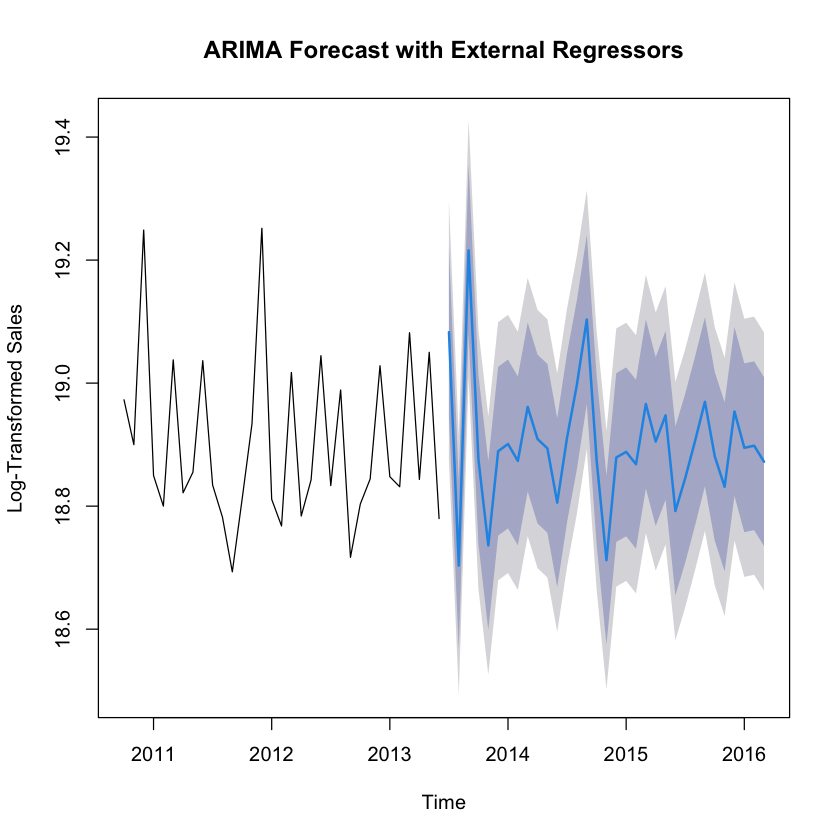

In [37]:
# Forecast the next 12 months
forecast_horizon <- 12
arima_forecast <- forecast(improved_arima, h = forecast_horizon, xreg = xreg_train_reduced)

# Plotting
plot(arima_forecast, 
     main = "ARIMA Forecast with External Regressors", 
     ylab = "Log-Transformed Sales", 
     xlab = "Time")

# Convert forecast back to original scale
forecast_original <- expm1(arima_forecast$mean)
lower_ci_original <- expm1(arima_forecast$lower[, 2])
upper_ci_original <- expm1(arima_forecast$upper[, 2])

# Evaluation Metrics
actuals <- ts_monthly_sales[(length(ts_monthly_sales) - forecast_horizon + 1):length(ts_monthly_sales)] # Dummy

# Calculate evaluation metrics
rmse_result <- sqrt(mean((actuals - expm1(arima_forecast$mean))^2))
mae_result <- mean(abs(actuals - expm1(arima_forecast$mean)))

cat("RMSE: ", rmse_result, "\n")
cat("MAE: ", mae_result, "\n")

# Create a data frame for forecast results
forecast_results <- data.frame(
  Time = seq_along(forecast_original),
  Forecast = forecast_original,
  Lower_CI = lower_ci_original,
  Upper_CI = upper_ci_original
)

# Display forecast results
print(forecast_results)

In [26]:
# Step 1: Aggregate the validation_set to monthly Total_Sales
valid_monthly <- validation_set %>%
  mutate(Year_Month = paste(Year, Month, sep = "-")) %>%
  group_by(Year_Month) %>%
  summarise(Total_Sales = sum(Weekly_Sales, na.rm = TRUE)) %>%
  ungroup()

# Step 2: Align forecasted and actual values
actual_values <- valid_monthly$Total_Sales

# Ensure alignment of lengths between actuals and forecasted values
forecasted_values <- as.numeric(arima_forecast$mean)
forecast_horizon <- min(length(actual_values), length(forecasted_values))
actual_values <- head(actual_values, forecast_horizon)
forecasted_values <- head(forecasted_values, forecast_horizon)

# Step 3: Calculate evaluation metrics
rmse_value <- rmse(actual_values, forecasted_values)
mae_value <- mae(actual_values, forecasted_values)
mape_value <- mape(actual_values, forecasted_values)

# Create a data frame to display the results
evaluation_metrics <- data.frame(
  Model = "Improved ARIMA",
  RMSE = rmse_value,
  MAE = mae_value,
  MAPE = mape_value
)

# Print evaluation metrics
print(evaluation_metrics)

           Model     RMSE      MAE      MAPE
1 Improved ARIMA 41370201 40867661 0.9999995


[1] "Baseline Model Evaluation Metrics:"
           Model    RMSE     MAE      MAPE
1  Mean Forecast 6428671 5155507 0.1223246
2 Naive Forecast 7285362 4740267 0.1023636


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


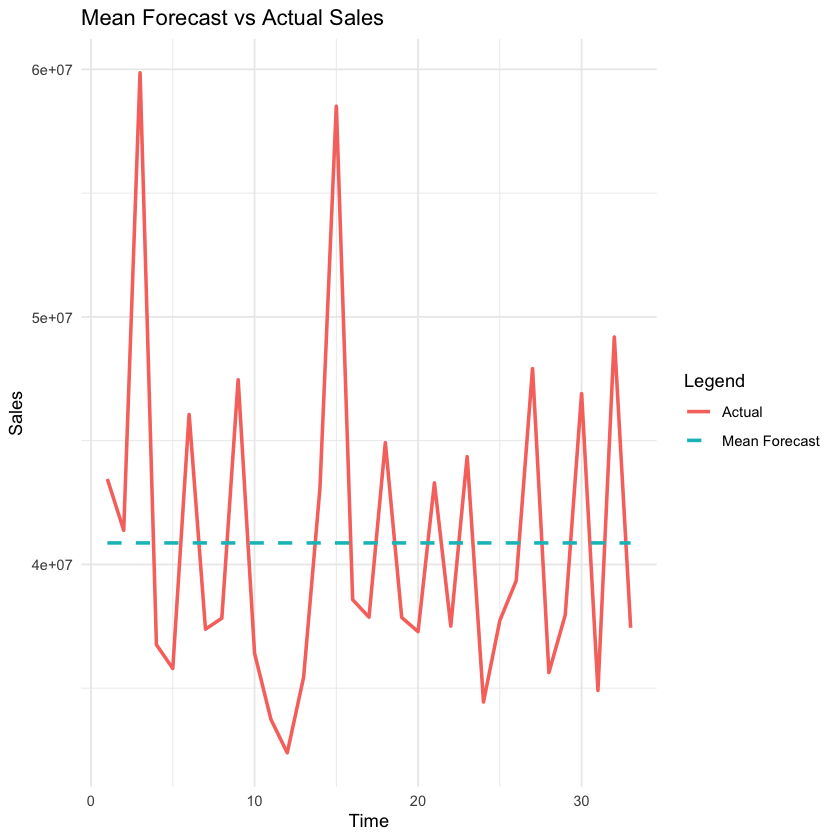

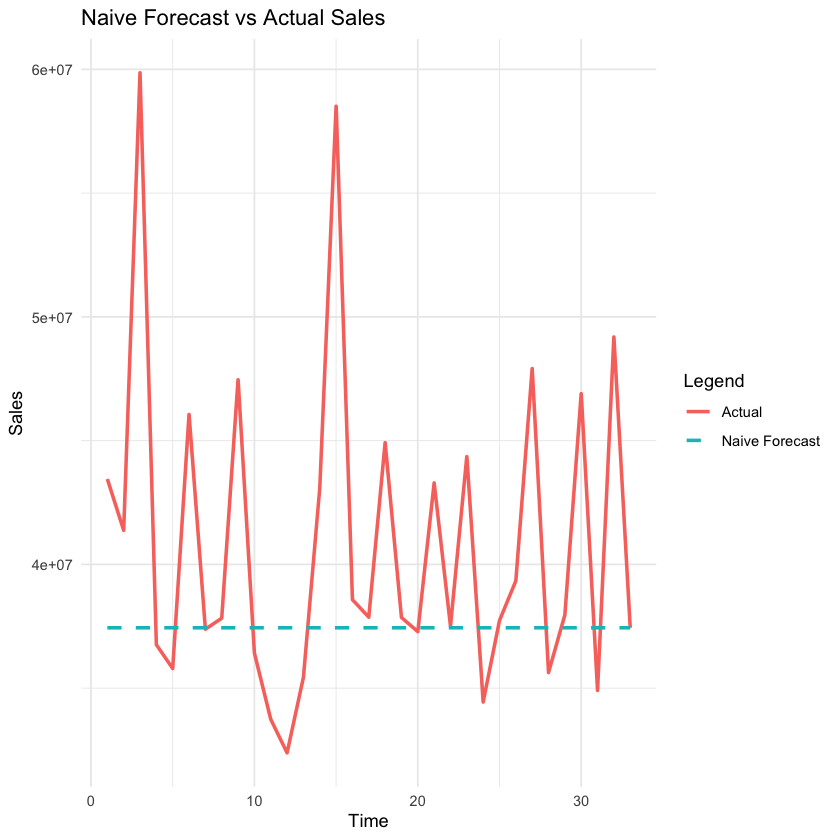

In [27]:
# Baseline Model 1: Mean Forecast
mean_forecast <- mean(actual_values, na.rm = TRUE)  # Average of actual sales
mean_forecast_values <- rep(mean_forecast, length(actual_values))

# Baseline Model 2: Naive Forecast
naive_forecast_values <- rep(tail(actual_values, 1), length(actual_values))

# Calculate Metrics for Baseline Models
baseline_metrics <- data.frame(
  Model = c("Mean Forecast", "Naive Forecast"),
  RMSE = c(
    rmse(actual_values, mean_forecast_values),
    rmse(actual_values, naive_forecast_values)
  ),
  MAE = c(
    mae(actual_values, mean_forecast_values),
    mae(actual_values, naive_forecast_values)
  ),
  MAPE = c(
    mape(actual_values, mean_forecast_values),
    mape(actual_values, naive_forecast_values)
  )
)

# Print Metrics
print("Baseline Model Evaluation Metrics:")
print(baseline_metrics)

# Plot Baseline Models vs Actuals
baseline_df <- data.frame(
  Time = 1:length(actual_values),
  Actual = actual_values,
  Mean_Forecast = mean_forecast_values,
  Naive_Forecast = naive_forecast_values
)

# Plot Mean Forecast
ggplot(baseline_df, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Mean_Forecast, color = "Mean Forecast"), linetype = "dashed", size = 1) +
  labs(
    title = "Mean Forecast vs Actual Sales",
    x = "Time",
    y = "Sales",
    color = "Legend"
  ) +
  theme_minimal()

# Plot Naive Forecast
ggplot(baseline_df, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Naive_Forecast, color = "Naive Forecast"), linetype = "dashed", size = 1) +
  labs(
    title = "Naive Forecast vs Actual Sales",
    x = "Time",
    y = "Sales",
    color = "Legend"
  ) +
  theme_minimal()


In [31]:
final_training_set <- bind_rows(train_set, validation_set)

In [38]:
# Aggregate data by month
final_monthly <- final_training_set %>%
  mutate(Year_Month = paste(Year, Month, sep = "-")) %>%
  group_by(Year_Month) %>%
  summarise(
    Total_Sales = sum(Weekly_Sales, na.rm = TRUE),
    Fuel_Price_Scaled = mean(Fuel_Price, na.rm = TRUE),
    Temperature_Scaled = mean(Temperature, na.rm = TRUE),
    CPI_Scaled = mean(CPI, na.rm = TRUE),
    Unemployment_Scaled = mean(Unemployment, na.rm = TRUE),
    IsHoliday = max(IsHoliday, na.rm = TRUE),
    Markdown_Avg = mean(Markdown_Avg, na.rm = TRUE)
  ) %>%
  ungroup()

  # Add lagged features and rolling averages
final_monthly <- final_monthly %>%
  mutate(
    Lag_1_Sales = lag(Total_Sales, n = 1),
    Lag_2_Sales = lag(Total_Sales, n = 2),
    Lag_3_Sales = lag(Total_Sales, n = 3),
    Rolling_3_Month_Avg = rollmean(Total_Sales, k = 3, fill = NA, align = "right")
  )

# Replace NA values with 0
final_monthly[is.na(final_monthly)] <- 0

In [39]:
# Convert aggregated sales to a time series
start_year <- as.numeric(substr(final_monthly$Year_Month[1], 1, 4))
start_month <- as.numeric(substr(final_monthly$Year_Month[1], 6, 7))
final_ts_sales <- ts(final_monthly$Total_Sales, start = c(start_year, start_month), frequency = 12)

# Prepare external regressors
xreg_final <- as.matrix(final_monthly[, c(
  "Fuel_Price_Scaled", "Temperature_Scaled", "CPI_Scaled", "Unemployment_Scaled",
  "IsHoliday", "Markdown_Avg", "Lag_1_Sales", "Lag_2_Sales", "Lag_3_Sales", "Rolling_3_Month_Avg"
)])

# Log-transform the time series for stationarity
final_ts_sales <- log1p(final_ts_sales)

# Compute correlation matrix for the regressors
cor_matrix <- cor(xreg_final, use = "complete.obs")

# Print the correlation matrix to identify highly correlated variables
print(cor_matrix)

# Remove highly correlated variables (threshold > 0.9)
cor_threshold <- 0.9
highly_correlated <- which(abs(cor_matrix) > cor_threshold & row(cor_matrix) != col(cor_matrix), arr.ind = TRUE)
drop_columns <- unique(colnames(xreg_final)[highly_correlated[, 2]])

# Print columns to drop
print(drop_columns)

# Filter out highly correlated columns from the regressors
xreg_final_reduced <- xreg_final[, !colnames(xreg_final) %in% drop_columns]

                    Fuel_Price_Scaled Temperature_Scaled  CPI_Scaled
Fuel_Price_Scaled          1.00000000         0.20943546  0.83009197
Temperature_Scaled         0.20943546         1.00000000  0.15401004
CPI_Scaled                 0.83009197         0.15401004  1.00000000
Unemployment_Scaled       -0.75647089        -0.16750193 -0.97829665
IsHoliday                 -0.19190346        -0.40233037 -0.05816556
Markdown_Avg               0.24962111        -0.23326744  0.50735411
Lag_1_Sales                0.05468393        -0.12558053  0.04493322
Lag_2_Sales                0.17847976         0.06935559  0.10352821
Lag_3_Sales                0.25592935         0.14115809  0.19322420
Rolling_3_Month_Avg        0.22514464         0.03864661  0.17890279
                    Unemployment_Scaled   IsHoliday Markdown_Avg Lag_1_Sales
Fuel_Price_Scaled           -0.75647089 -0.19190346   0.24962111  0.05468393
Temperature_Scaled          -0.16750193 -0.40233037  -0.23326744 -0.12558053
CPI_Scaled

In [40]:
# Fit the ARIMA model
final_arima_model <- auto.arima(
  final_ts_sales,
  seasonal = TRUE,
  stepwise = TRUE,
  approximation = FALSE,
  xreg = xreg_final_reduced
)

# Print the ARIMA model summary
print(summary(final_arima_model))

Series: final_ts_sales 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept  Fuel_Price_Scaled  Temperature_Scaled  IsHoliday  Markdown_Avg
        19.3013            -0.0111              0.0007     0.0528         0e+00
s.e.     0.1605             0.0433              0.0012     0.0475         2e-04
      Lag_1_Sales  Lag_2_Sales  Lag_3_Sales  Rolling_3_Month_Avg
            0e+00        0e+00        0e+00                0e+00
s.e.        2e-04        2e-04        2e-04                2e-04

sigma^2 = 0.01179:  log likelihood = 31.7
AIC=-43.41   AICc=-33.41   BIC=-28.44

Training set error measures:
                        ME      RMSE        MAE          MPE      MAPE     MASE
Training set -6.783715e-15 0.0925804 0.08141191 -0.002333106 0.4252897 1.134629
                   ACF1
Training set -0.1833616


   Time  Forecast  Lower_CI  Upper_CI
1     1 242130381 195723387 299540705
2     2 166181814 134331212 205584354
3     3 278323849 224979973 344315826
4     4 196098545 158514067 242594491
5     5 170801988 138065878 211299994
6     6 199276682 161083078 246526179
7     7 201936420 163233048 249816555
8     8 195714550 158203669 242119448
9     9 213696773 172739398 264365347
10   10 202142700 163399792 250071745
11   11 199011206 160868484 246197758
12   12 184611984 149229034 228384408
13   13 204703349 165469664 253239537
14   14 224186116 181218341 277341765
15   15 248823378 201133597 307820646
16   16 197695623 159805047 244570244
17   17 168238458 135993677 208128638
18   18 197037436 159273009 243755997
19   19 199424859 161202856 246709490
20   20 194799510 157464006 240987448
21   21 213321579 172436114 263901193
22   22 202332218 163552987 250306199
23   23 212705458 171938080 263138986
24   24 182727406 147705656 226052987
25   25 191915685 155132899 237419853
26   26 2040

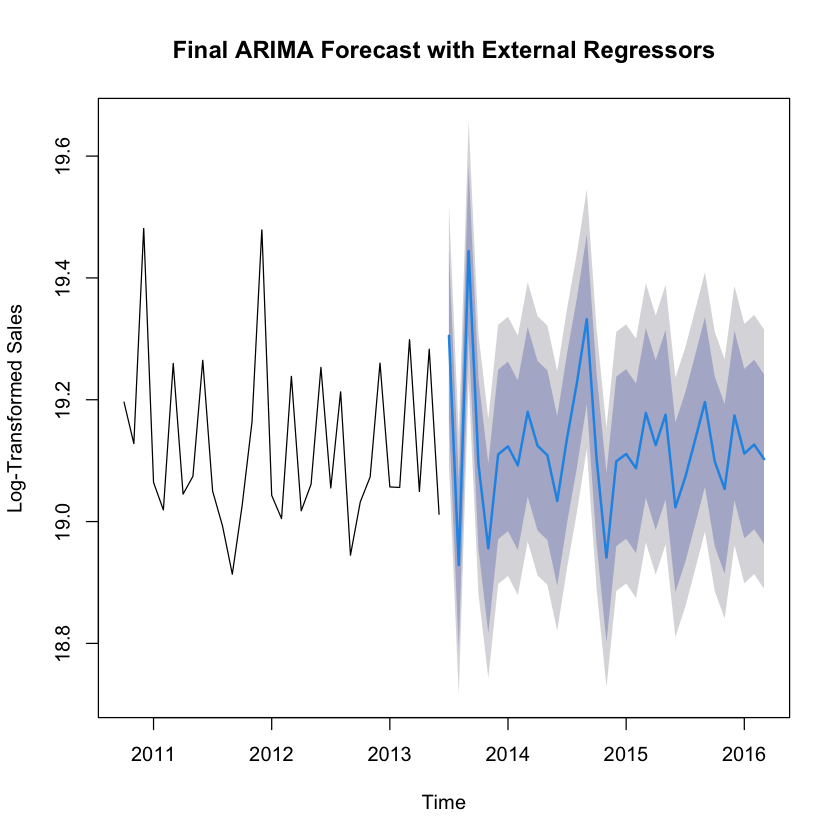

In [41]:
# Forecast for the next 12 months (adjust horizon as needed)
forecast_horizon <- 12
final_forecast <- forecast(final_arima_model, h = forecast_horizon, xreg = xreg_final_reduced)

# Convert forecast back to original scale
forecast_original <- expm1(final_forecast$mean)
lower_ci_original <- expm1(final_forecast$lower[, 2])
upper_ci_original <- expm1(final_forecast$upper[, 2])

# Create a data frame for the forecast results
forecast_results <- data.frame(
  Time = seq_along(forecast_original),
  Forecast = forecast_original,
  Lower_CI = lower_ci_original,
  Upper_CI = upper_ci_original
)

# Print the forecast results
print(forecast_results)

# Plot the forecast
plot(final_forecast, 
     main = "Final ARIMA Forecast with External Regressors", 
     ylab = "Log-Transformed Sales", 
     xlab = "Time")